# How To Create TFRecords
In this notebook, we learn how to create TFRecords to train TensorFlow models. We will create TFRecords from the Kaggle dataset of 512x512x3 jpegs [here][1]. This dataset contains the Melanoma Classification competition data (train 30,000 and test 10,000 ) and an additional 30,000 external images. It was published by [Alex Shonenkov][2]

There is a discussion post about these TFRecords [here][3] and Alex discusses where these images came from [here][4]

[1]: https://www.kaggle.com/shonenkov/melanoma-merged-external-data-512x512-jpeg
[2]: https://www.kaggle.com/shonenkov
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/156245
[4]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155859

# Load Meta Data

In [1]:
# LOAD LIBRARIES
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
import tensorflow as tf, re, math

/Users/vignavramesh/.pyenv/versions/3.6.10/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vignavramesh/.pyenv/versions/3.6.10/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vignavramesh/.pyenv/versions/3.6.10/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
# PATHS TO IMAGES
PATH = 'stylized-input/'
IMGS = os.listdir(PATH)
print('There are %i train images'%(len(IMGS)))

There are 35123 train images


In [3]:
# LOAD TRAIN META DATA
df = pd.read_csv('trainLabels.csv')
df.rename({'level':'label'},axis=1,inplace=True)
df.head()

,image,label
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [4]:
# LOAD TEST META DATA
# test = pd.read_csv('siim-isic-melanoma-classification/test.csv')
# test.head()

# Label Encode Meta Data
It is more efficient to store this meta data as integers instead of strings. We will impute the Age NaNs to Age mean. Then all other NaNs will be convert to `-1` and the other strings will be converted to `0, 1, 2, 3, ...` in the order they appear in the printed lists below.

In [5]:
# COMBINE TRAIN AND TEST TO ENCODE TOGETHER
# comb = df.reset_index(drop=True)
# comb = df

In [6]:
# LABEL ENCODE ALL STRINGS
# cats = ['patient_id','sex','anatom_site_general_challenge'] 
# for c in cats:
#     comb[c],mp = comb[c].factorize()
#     print(mp)
# print('Imputing Age NaN count =',comb.age_approx.isnull().sum())
# comb.age_approx.fillna(comb.age_approx.mean(),inplace=True)
# comb['age_approx'] = comb.age_approx.astype('int')

In [7]:
# REWRITE DATA TO DATAFRAMES
# df[cols] = comb.loc[:df.shape[0]-1,cols].values
# test[cols] = comb.loc[df.shape[0]:,cols].values

In [8]:
# LABEL ENCODE TRAIN SOURCE
# df.source,mp = df.source.factorize()
# print(mp)

> # Write TFRecords - Train
All the code below comes from TensorFlow's docs [here][1]

[1]: https://www.tensorflow.org/tutorials/load_data/tfrecord

In [9]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [10]:
def serialize_example(feature0, feature1, feature2, feature3):
    feature = {
        'image': _bytes_feature(feature0),
        'label': _int64_feature(feature1),
        'patient_id': _int64_feature(feature2),
        'side': _int64_feature(feature3)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [11]:
SIZE = 2071
CT = len(IMGS)//SIZE + int(len(IMGS)%SIZE!=0)
for j in range(CT):
    print(); print('Writing TFRecord %i of %i...'%(j,CT))
    CT2 = min(SIZE,len(IMGS)-j*SIZE)
    with tf.io.TFRecordWriter('train%.2i-%i.tfrec'%(j,CT2)) as writer:
        for k in range(CT2):
            img = cv2.imread(PATH+IMGS[SIZE*j+k])
            try:
                img = cv2.resize(img, (256,256))
            except:
                print(PATH+IMGS[SIZE*j+k])
                raise
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            name = IMGS[SIZE*j+k].split('.')[0]
            patient_id = int(name.split("_")[0])
            if name.split("_")[1] == "left":
                side = 0
            else:
                side = 1
            row = df.loc[df.image==name]
            example = serialize_example(
                img, 
                row.label.values[0],
                patient_id,
                side)
            writer.write(example)
            if k%100==0: print(k,', ',end='')


Writing TFRecord 0 of 17...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 
Writing TFRecord 1 of 17...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 
Writing TFRecord 2 of 17...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 
Writing TFRecord 3 of 17...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 
Writing TFRecord 4 of 17...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 
Writing TFRecord 5 of 17...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 
Writing TFRecor

In [12]:
! ls -l

total 115753576
drwxr-xr-x@    15 vignavramesh  staff          480 Feb 27 14:00 Documents - Vignav’s MacBook Pro
drwxr-xr-x@     4 vignavramesh  staff          128 Nov  5 07:06 Game Design I&II
-rw-r--r--@     1 vignavramesh  staff      7509935 Mar 15 11:54 Initial-Website-master.zip
drwxr-xr-x@     3 vignavramesh  staff           96 Feb 27 14:00 MATLAB
drwxr-xr-x@     4 vignavramesh  staff          128 Dec 24 00:02 My EndNote Library.Data
-rw-r--r--@     1 vignavramesh  staff        12288 Dec 18 20:45 My EndNote Library.enl
drwxr-xr-x@     2 vignavramesh  staff           64 Nov  5 07:06 Pillayar Machi
drwxr-xr-x@    13 vignavramesh  staff          416 Feb 27 14:00 Roblox
drwxr-xr-x@     9 vignavramesh  staff          288 Nov  5 07:06 TI-Nspire CX
drwxr-xr-x@     3 vignavramesh  staff           96 Nov  5 07:06 WeDo
drwxr-xr-x@     2 vignavramesh  staff           64 Nov  5 07:06 Wolfram Desktop
drwxr-xr-x@     3 vignavramesh  staff           96 Feb 27 14:00 cli
drwxr-xr-x@    47 vignavr

# Write TFRecords - Test

In [13]:
# def serialize_example2(feature0, feature1, feature2, feature3, feature4, feature5): 
#   feature = {
#       'image': _bytes_feature(feature0),
#       'image_name': _bytes_feature(feature1),
#       'patient_id': _int64_feature(feature2),
#       'sex': _int64_feature(feature3),
#       'age_approx': _int64_feature(feature4),
#       'anatom_site_general_challenge': _int64_feature(feature5),
#   }
#   example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#   return example_proto.SerializeToString()

In [14]:
# SIZE = 687
# CT = len(IMGS2)//SIZE + int(len(IMGS2)%SIZE!=0)
# for j in range(CT):
#     print(); print('Writing TFRecord %i of %i...'%(j,CT))
#     CT2 = min(SIZE,len(IMGS2)-j*SIZE)
#     with tf.io.TFRecordWriter('test%.2i-%i.tfrec'%(j,CT2)) as writer:
#         for k in range(CT2):
#             img = cv2.imread(PATH2+IMGS2[SIZE*j+k])
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
#             img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
#             name = IMGS2[SIZE*j+k].split('.')[0]
#             row = test.loc[test.image_name==name]
#             example = serialize_example2(
#                 img, str.encode(name),
#                 row.patient_id.values[0],
#                 row.sex.values[0],
#                 row.age_approx.values[0],                        
#                 row.anatom_site_general_challenge.values[0])
#             writer.write(example)
#             if k%100==0: print(k,', ',end='')

# Verify TFRecords
We will verify the TFRecords we just made by using code from the Flower Comp starter notebook [here][1] to display the TFRecords below.

[1]: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu

In [15]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [16]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    label = example['label']
    
    return image, label

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [17]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [256,256]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('train*.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))

There are 35123 train images


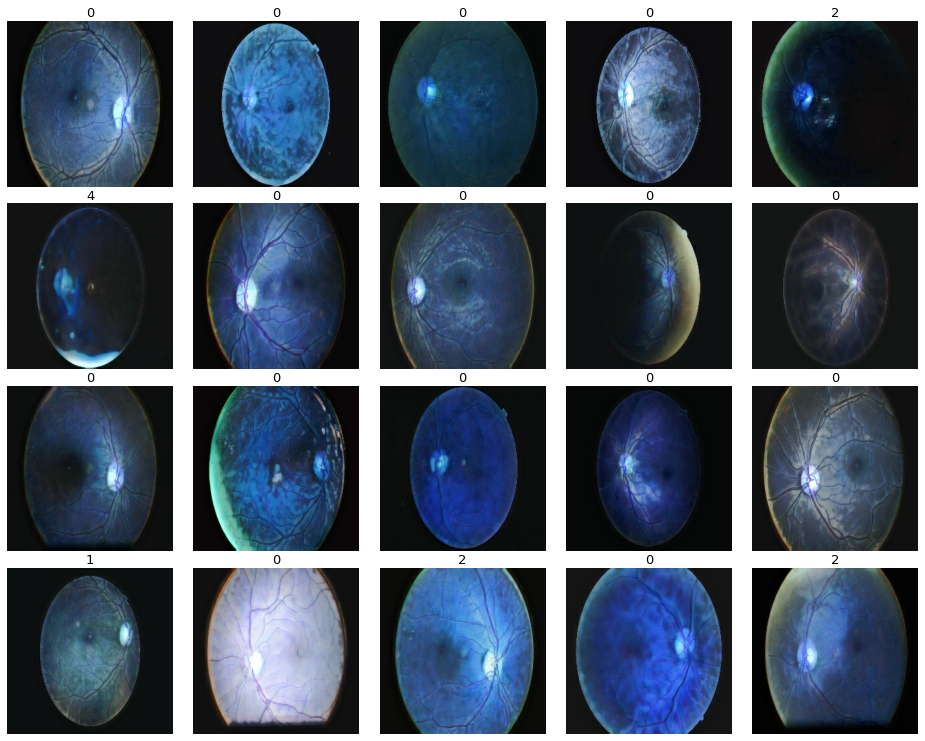

In [18]:
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))